In [67]:
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import contextily as ctx
from pyproj import CRS, Transformer
from matplotlib.colors import Normalize, ListedColormap
from shapely.geometry import Point

def set_plot_limits(ax, lon_min, lon_max, lat_min, lat_max):
    # Transformer for converting between WGS84 and Web Mercator
    transformer = Transformer.from_crs("EPSG:4326", "EPSG:3857")
    # Transform input coordinates to Web Mercator
    x_min, y_min = transformer.transform(lat_min, lon_min)
    x_max, y_max = transformer.transform(lat_max, lon_max)
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)

def findControlPoint(gdf_mercator, element, opts):
    # Create a GeoDataFrame with control point
    control_point = gpd.GeoDataFrame(geometry=[Point(opts['control_lon'], opts['control_lat'])], crs='EPSG:4326').to_crs(epsg=3857)
    # Calculate distance to control point
    gdf_mercator['distance_to_control'] = gdf_mercator.geometry.distance(control_point.geometry[0])

    # Subset to points within max distance
    least_contaminated = gdf_mercator.loc[gdf_mercator['distance_to_control'] <= opts['max_distance']]
    control_x, control_y, control_concentration = (
        least_contaminated['x'].mean(),
        least_contaminated['y'].mean(),
        least_contaminated[element].mean()
    )
    return control_x, control_y, control_concentration

def add_inset_map(ax, lon1, lat1, lon2, lat2,gdf,control_gdf):
    from mpl_toolkits.axes_grid1.inset_locator import inset_axes
    transformer_inset = Transformer.from_crs('EPSG:4326', 'EPSG:3857')
    iax = inset_axes(ax, width="33%", height="35%", loc=1)
    inset_xmin, inset_ymin = transformer_inset.transform(lat1, lon1)
    inset_xmax, inset_ymax = transformer_inset.transform(lat2, lon2)
    iax.set_xlim(min(inset_xmin, inset_xmax), max(inset_xmin, inset_xmax))
    iax.set_ylim(min(inset_ymin, inset_ymax), max(inset_ymin, inset_ymax))
    
    iax.scatter(gdf.geometry.x, gdf.geometry.y, color='black')
    iax.scatter(control_gdf.geometry.x, control_gdf.geometry.y, color='blue')

    ctx.add_basemap(iax, source=ctx.providers.OpenTopoMap, zoom=11, attribution_size=0)
    main_xmin, main_xmax =  ax.get_xlim()
    main_ymin, main_ymax =  ax.get_ylim()
    iax.plot([main_xmin, main_xmin, main_xmax, main_xmax, main_xmin],
             [main_ymin, main_ymax, main_ymax, main_ymin, main_ymin],
             color='red', linewidth=1.5, linestyle='-')
    iax.set_xticks([]), iax.set_yticks([])
    

def process_file(file_name, element, opts):
    df = pd.read_csv(file_name, na_values='< LOD')
    
    gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df['x'], df['y']), crs='EPSG:4326')
    gdf = gdf.to_crs(epsg=3857) # Convert coordinate reference system
    gdf = gdf.dropna(subset=[element])
    control_x, control_y, control_concentration  = findControlPoint(gdf,element,opts)
    control_gdf = gpd.GeoDataFrame(geometry=gpd.points_from_xy([control_x],
                            [control_y]), crs='EPSG:4326').to_crs(epsg=3857)
    
    # now remove points in a gdf that is focussed on a specific area: gdf_filt
    df = df[
        (df['y'] <= opts['ignore_lat_max']) &
        (df['y'] >= opts['ignore_lat_min']) &
        (df['x'] <= opts['ignore_lon_max']) &
        (df['x'] >= opts['ignore_lon_min'])
    ]
    gdf_filt = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df['x'], df['y']), crs='EPSG:4326')
    gdf_filt = gdf_filt.to_crs(epsg=3857) # Convert coordinate reference system
    gdf_filt = gdf_filt.dropna(subset=[element])
    gdf_filt['element_deltaX'] = gdf_filt[element]-control_concentration
     
    return gdf, gdf_filt, control_gdf



def plot_contamination_map(file_name, element, opts):
    gdf, gdf_filt, control_gdf = process_file(file_name, element, opts)
    
    cmap = ListedColormap([plt.cm.viridis(i / 10) for i in range(10)])
    fig, ax = plt.subplots(figsize=(10, 10))
    
    # Normalize the element_deltaX values for colormap
    gdf_filt["normalized_contamination"] = Normalize()(gdf_filt['element_deltaX'])

    # Sort GeoDataFrame based on normalized contamination
    gdf_filt = gdf_filt.sort_values(by="normalized_contamination")

    # Plot the points with color based on relative contamination
    scatter = ax.scatter(gdf_filt.geometry.x, gdf_filt.geometry.y, c=gdf_filt["normalized_contamination"], cmap=cmap, s=50)

    # Set plot limits
    set_plot_limits(ax, opts['map_lon_min'], opts['map_lon_max'], opts['map_lat_min'], opts['map_lat_max'])

    # Plot the base map
    ctx.add_basemap(ax, source=ctx.providers.OpenTopoMap)

    # Add a colorbar
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=Normalize(vmin=gdf_filt['element_deltaX'].min(), 
                                                         vmax=gdf_filt['element_deltaX'].max()))
    sm.set_array([])
    colorbar = fig.colorbar(sm, ax=ax, orientation='vertical', shrink=0.4)
    colorbar.set_label(f'Difference in {element} Concentration Relative to Control Point (ppm)')
    
    xmin, xmax = ax.get_xlim()
    ymin, ymax = ax.get_ylim()
    xticks = np.linspace(xmin, xmax, num=5)
    yticks = np.linspace(ymin, ymax, num=5)
    transformer = Transformer.from_crs("epsg:3857", "epsg:4326")
    xticklabels = [round(transformer.transform(x, ymin)[1], 4) for x in xticks]
    yticklabels = [round(transformer.transform(xmin, y)[0], 4) for y in yticks]
    ax.set_xticks(xticks)
    ax.set_yticks(yticks)
    ax.set_xticklabels(xticklabels)
    ax.set_yticklabels(yticklabels)
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    
    
    plt.title('Soil Sample Locations and Contamination Relative to Control Point')
    
    add_inset_map(ax,-60.595,53.259, -60.30, 53.404,gdf,control_gdf) # Add inset map
    plt.savefig(f"./plots/contamination_map_{element}.png", dpi=300)
    


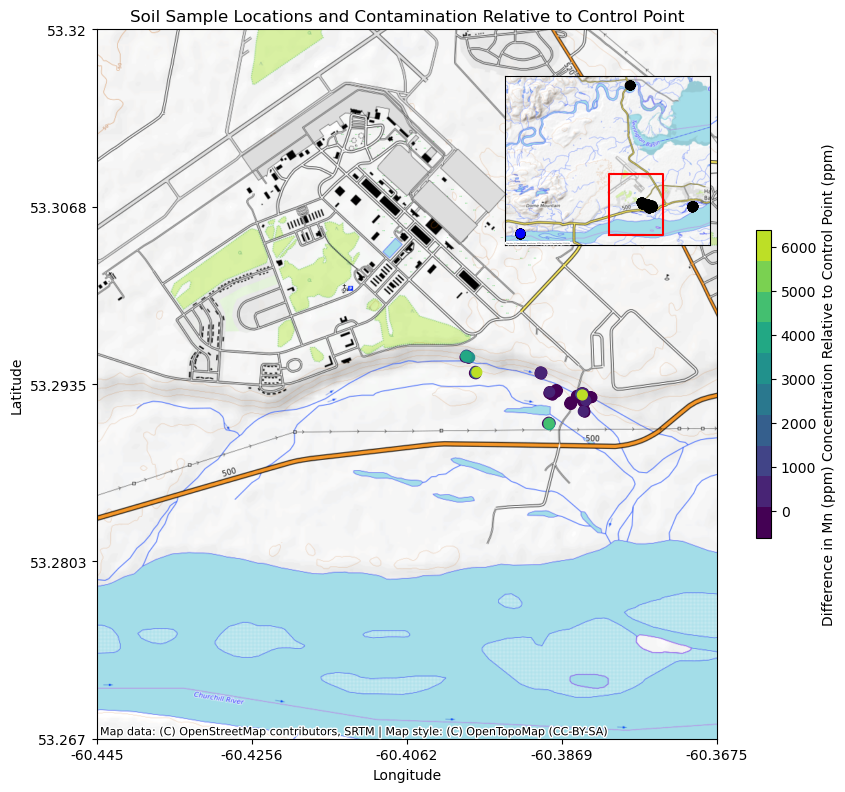

In [69]:
# map and data options
options = {
    'max_distance': 200, # the max distance to consider for cluster control point cluster
    'control_lon':  -60.574290,
    'control_lat':  53.268397,
    'map_lon_min': -60.445, # map plot limits to keep plots consistent
    'map_lon_max': -60.3675,
    'map_lat_min': 53.267,
    'map_lat_max': 53.32,
    'ignore_lat_min': 53.267, # data limits to consider
    'ignore_lat_max': 53.32,
    'ignore_lon_min': -60.445,
    'ignore_lon_max': -60.36,   
}

filename = 'soil_samples.csv'
element = 'Mn (ppm)'
plot_contamination_map(filename,element,options)